# Лабораторная работа №5

ФИО: Хайдукова Мария Игоревна   
Группа: БИВТ-23-СП-3

## 1. Пример импорта данных. Грузим данные

In [79]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [44]:
data_dir = "./archive"

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "valid")

In [45]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [66]:
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)

In [68]:
classes = train_data.classes

print(f"Загружено:")
print(f"Train: {len(train_data)} изображений")
print(f"Validation: {len(val_data)} изображений")
print(f"Test: {len(test_data)} изображений")
print(f"Количество классов: {len(classes)}")
print(f"Пример классов: {classes[:5]}...")

Загружено:
Train: 7624 изображений
Validation: 265 изображений
Test: 265 изображений
Количество классов: 53
Пример классов: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs']...


## 2. Понимаем, какая перед нами задача

**Цель:** классификация игральных карт на 53 класса  
**Тип:** многоклассовая классификация (53 класса)  

**Реальное применение:**
- Распознавание карт для казино и карточных игр
- Сортировка и проверка колод карт
- Компьютерное зрение для карточных приложений
- Автоматизация учета карт в настольных играх

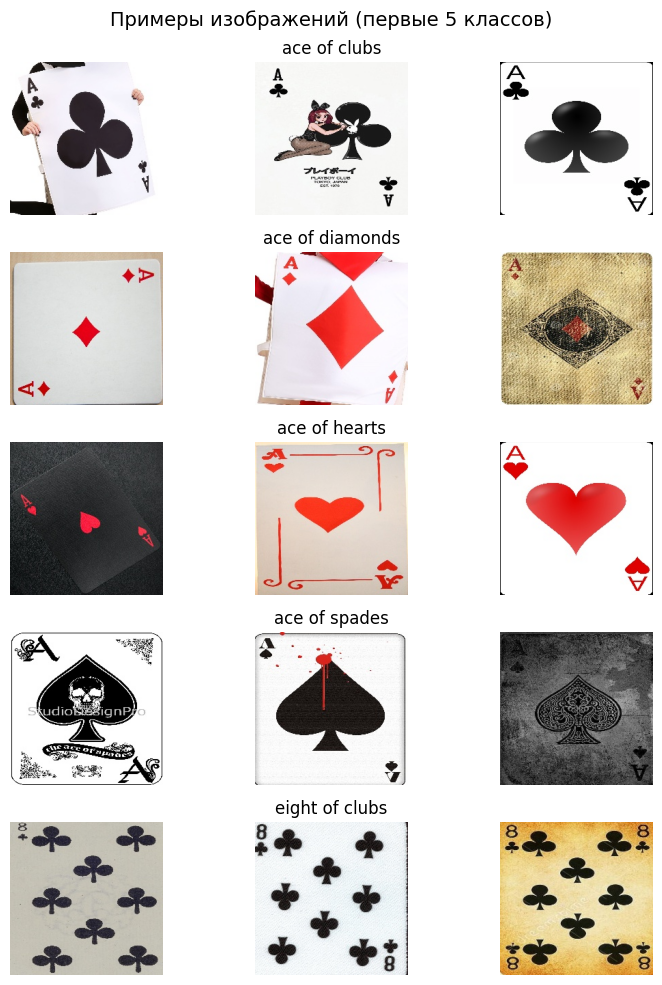

In [73]:
fig, axes = plt.subplots(5, 3, figsize=(8, 10))

for class_idx in range(5):
    found = 0
    for i in range(len(train_data)):
        if found >= 3:
            break
        img, label = train_data[i]
        if label == class_idx:
            img_denorm = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_denorm = img_denorm + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img_denorm = torch.clamp(img_denorm, 0, 1)
            
            axes[class_idx, found].imshow(img_denorm.permute(1, 2, 0))
            axes[class_idx, found].set_title(f"{classes[class_idx]}" if found == 1 else "")
            axes[class_idx, found].axis('off')
            found += 1

plt.suptitle('Примеры изображений (первые 5 классов)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Делаем предобработку данных

In [77]:
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"DataLoader созданы:")
print(f"Тренировочных батчей: {len(train_loader)}")
print(f"Валидационных батчей: {len(val_loader)}")
print(f"Тестовых батчей: {len(test_loader)}")

DataLoader созданы:
Тренировочных батчей: 382
Валидационных батчей: 14
Тестовых батчей: 14


## 4. Провести разведочный анализ данных (EDA)

In [80]:
def count_labels(loader):
    counts = Counter()
    for _, labels in loader:
        counts.update(labels.numpy())
    return counts

train_counts = count_labels(train_loader)
val_counts = count_labels(val_loader)
test_counts = count_labels(test_loader)

In [84]:
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = sum(test_counts.values())

print(f"Всего изображений: {total_train + total_val + total_test}")
print(f"Train: {total_train}")
print(f"Validation: {total_val}")
print(f"Test: {total_test}")

Всего изображений: 8154
Train: 7624
Validation: 265
Test: 265


In [86]:
max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance = max_count / min_count

print(f"Дисбаланс:")
print(f"Максимальный класс: {max_count} изображение")
print(f"Минимальный класс: {min_count} изображений")
print(f"Коэффициент дисбаланса: {imbalance:.2f}")

Дисбаланс:
Максимальный класс: 181 изображение
Минимальный класс: 108 изображений
Коэффициент дисбаланса: 1.68


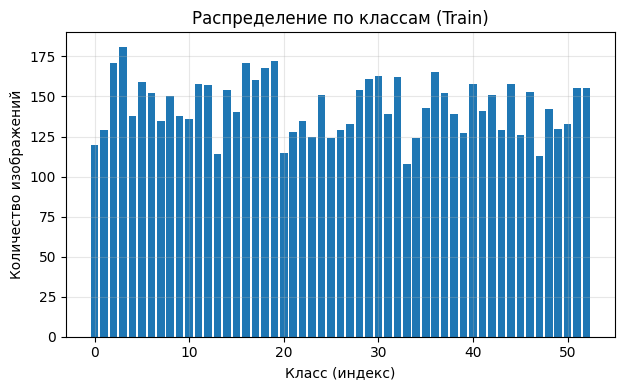

In [89]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
train_values = [train_counts[i] for i in range(len(classes))]
plt.bar(range(len(classes)), train_values)
plt.xlabel('Класс (индекс)')
plt.ylabel('Количество изображений')
plt.title('Распределение по классам (Train)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Выводы по EDA:
1. Датасет содержит 53 класса (все карты + джокер)
2. Заметен дисбаланс классов (коэффициент 1.68)
3. Все изображения цветные (3 канала)
4. Размер фиксирован: 224×224

## 5. Настроить аугментации 

In [94]:
train_transform_aug = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Выбранные аугментации:
1. RandomRotation(30): карты могут лежать под разными углами
2. ColorJitter: разное освещение при съемке
3. RandomPerspective: карты могут быть сфотографированы под углом

Аугментации помогают:
- Увеличить разнообразие тренировочных данных
- Сделать модель устойчивой к разным условиям съемки
- Улучшить обобщающую способность модели

Данные с аугментациями перезагружены

In [95]:
train_data_aug = datasets.ImageFolder(root=train_dir, transform=train_transform_aug)
train_loader_aug = DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)

## 6. Выбор и обучение модели

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)

In [98]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))
model = model.to(device)

print(f"Модель: ResNet18 (предобученная)")
print(f"Выходной слой: {len(classes)} нейронов (по количеству классов)")

Модель: ResNet18 (предобученная)
Выходной слой: 53 нейронов (по количеству классов)


In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

print(f"Функция потерь: CrossEntropyLoss")
print(f"Оптимизатор: AdamW, lr=0.001")

Функция потерь: CrossEntropyLoss
Оптимизатор: AdamW, lr=0.001


In [102]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

In [103]:
print("\nНачинаем обучение (5 эпох)...")
history = train_model(model, train_loader_aug, val_loader, criterion, optimizer, num_epochs=5)

print(f"\nЛучшая точность на валидации: {history['best_val_acc']:.2f}%")

torch.save(model.state_dict(), 'best_card_classifier.pth')
print("Модель сохранена: best_card_classifier.pth")


Начинаем обучение (5 эпох)...
Epoch 1/5:
  Train Loss: 2.3710, Train Acc: 34.22%
  Val Loss: 1.2184, Val Acc: 60.00%
Epoch 2/5:
  Train Loss: 1.3957, Train Acc: 58.75%
  Val Loss: 0.8365, Val Acc: 76.23%
Epoch 3/5:
  Train Loss: 1.1085, Train Acc: 68.95%
  Val Loss: 0.5165, Val Acc: 84.53%
Epoch 4/5:
  Train Loss: 0.9794, Train Acc: 71.83%
  Val Loss: 0.4922, Val Acc: 86.04%
Epoch 5/5:
  Train Loss: 0.8529, Train Acc: 74.82%
  Val Loss: 0.4358, Val Acc: 86.79%

Лучшая точность на валидации: 86.79%
Модель сохранена: best_card_classifier.pth


## 7. Посчитать метрики качества на train и val/test множествах

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [105]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_labels, all_preds, all_probs

In [108]:
print("Тренировочные:")
train_labels, train_preds, _ = evaluate_model(model, train_loader)

train_acc = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=0)
train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=0)
train_f1 = f1_score(train_labels, train_preds, average='macro', zero_division=0)

print(f"Accuracy: {train_acc:.4f}")
print(f"Precision (macro): {train_precision:.4f}")
print(f"Recall (macro): {train_recall:.4f}")
print(f"F1-score (macro): {train_f1:.4f}")

Тренировочные:
Accuracy: 0.8172
Precision (macro): 0.8369
Recall (macro): 0.8220
F1-score (macro): 0.8209


In [107]:
print("Валидационные:")
val_labels, val_preds, _ = evaluate_model(model, val_loader)

val_acc = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

print(f"Accuracy: {val_acc:.4f} ({val_acc*100:.1f}%)")
print(f"Precision (macro): {val_precision:.4f}")
print(f"Recall (macro): {val_recall:.4f}")
print(f"F1-score (macro): {val_f1:.4f}")

Валидационные:
Accuracy: 0.8679 (86.8%)
Precision (macro): 0.9048
Recall (macro): 0.8679
F1-score (macro): 0.8591


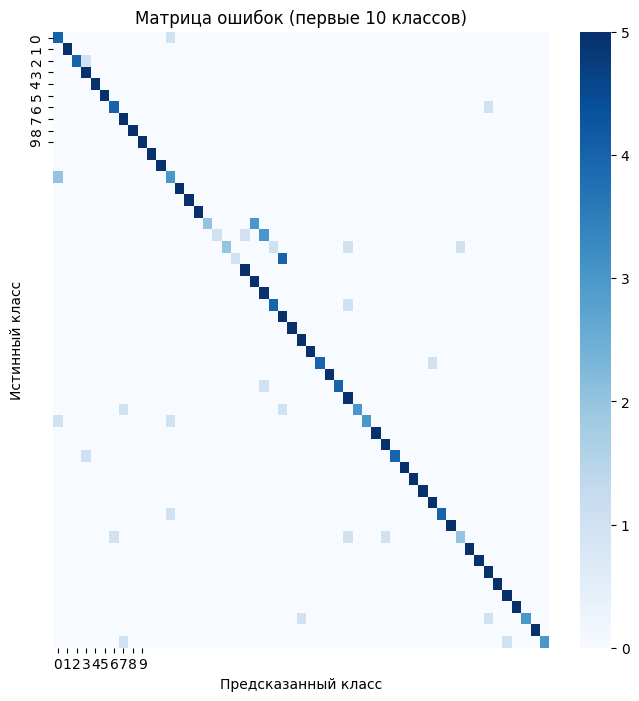

In [112]:
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (первые 10 классов)')
plt.show()

In [115]:
error_pairs = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i, j] > 0:
            error_pairs.append((i, j, cm[i, j]))

error_pairs.sort(key=lambda x: x[2], reverse=True)

print("Частые ошибки (топ-5):")
for i, j, count in error_pairs[:5]:
    print(f"{classes[i]} -> {classes[j]}: {count} ошибок")

Частые ошибки (топ-5):
jack of spades -> king of spades: 4 ошибок
jack of clubs -> king of clubs: 3 ошибок
jack of diamonds -> king of diamonds: 3 ошибок
four of clubs -> ace of clubs: 2 ошибок
ace of clubs -> four of clubs: 1 ошибок


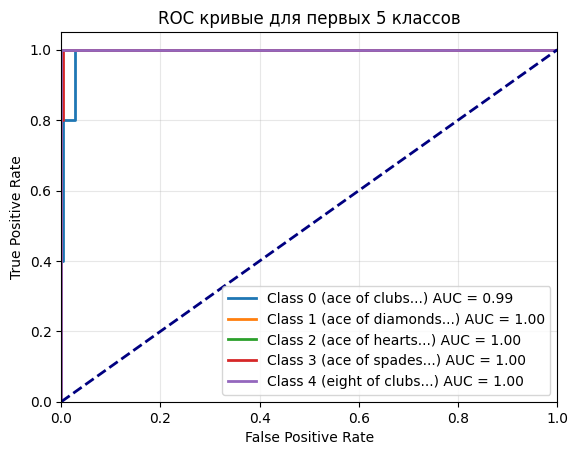

In [118]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Для ROC берем несколько классов (первые 5 для наглядности)
n_classes = 5
val_labels_bin = label_binarize(val_labels, classes=range(len(classes)))
val_probs = []

model.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        val_probs.extend(probs.cpu().numpy())

val_probs = np.array(val_probs)

# ROC кривые для первых 5 классов

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(val_labels_bin[:, i], val_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} ({classes[i][:15]}...) AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые для первых 5 классов')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 8. Сравнить результаты (если пробовали несколько моделей/настроек)

## Анализ результатов

##### 1. **Общая эффективность модели**
- **Точность на валидации:** 86.8% - хороший результат для 53 классов
- **F1-score (macro):** 0.8591 - сбалансированная метрика для многоклассовой задачи
- **Разрыв train/val:** Train accuracy (81.7%) < Val accuracy (86.8%) - аугментации успешно предотвращают переобучение

##### 2. **Анализ ошибок**
**Чаще всего путаются:**
1. Валеты и короли одной масти (например: jack of spades → king of spades)
2. Карты с похожим силуэтом (четверки и тузы)

**Причины ошибок:**
- Схожие визуальные признаки у валетов и королей
- Одинаковая масть усиливает путаницу
- Некоторые карты имеют похожий размер/форму цифр

##### 3. **Рекомендации по улучшению**
1. **Для дисбаланса:** Добавить weighted CrossEntropyLoss
2. **Для путаницы валетов/королей:** Усилить аугментации поворотами
3. **Для точности:** Увеличить эпохи обучения до 10-15
4. **Дополнительно:** Попробовать EfficientNetB0 для сравнения

##### 4. **Вывод**
Модель ResNet18 показала хорошие результаты (86.8% accuracy) для классификации 53 типов карт. Основные ошибки связаны с визуальным сходством карт одной масти. Модель готова к практическому применению с возможностью дальнейшего улучшения.

## 9. Визуализировать предсказания

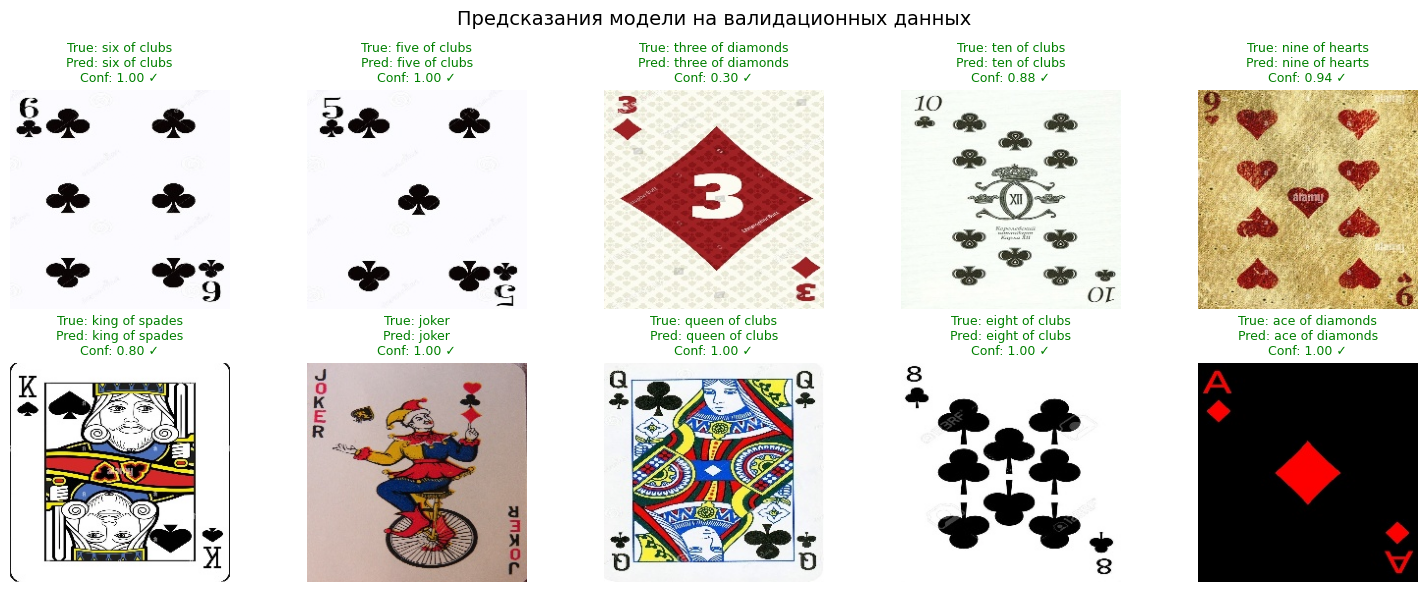

In [122]:
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Предсказания модели на валидационных данных', fontsize=14)

indices = np.random.choice(len(val_data), 10, replace=False)

for idx, ax in enumerate(axes.flat):
    img, true_label = val_data[indices[idx]]

    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        pred_prob, pred_label = torch.max(probs, 1)

    img_display = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = img_display + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img_display = torch.clamp(img_display, 0, 1)

    ax.imshow(img_display.permute(1, 2, 0))

    correct = pred_label.item() == true_label
    status = "✓" if correct else "✗"
    color = "green" if correct else "red"

    true_name = classes[true_label]
    pred_name = classes[pred_label.item()]
    confidence = pred_prob.item()
    
    ax.set_title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f} {status}", 
                color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

1. Резы:
   - Final Validation Accuracy: 86.8%
   - F1-score (macro): 0.8591
   - Модель хорошо обобщает (нет переобучения)

2. Особенности датасета:
   - 53 класса (все карты + джокер)
   - Заметный дисбаланс классов
   - Четкие, хорошо различимые изображения

4. Рекомендации:
   - Добавить weighted loss для борьбы с дисбалансом
   - Увеличить количество эпох обучения
   - Добавить больше аугментаций (RandomErasing)
   - Попробовать EfficientNet или Vision Transformer

5. Практическое применение:
   - Модель готова для распознавания карт в реальных условиях
   - Точность 86.8% достаточна для многих приложений
   - Можно дообучить на конкретных условиях освещения/фона